In [1]:
from dotenv import load_dotenv
from label_studio_sdk.client import LabelStudio
from glob import glob
from pathlib import Path
from sqlite3 import connect
from typing import Tuple
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [13]:
load_dotenv()

True

In [14]:
LABEL_STUDIO_URL = "https://labeler.e4e.ucsd.edu"
LABEL_STUDIO_API_KEY = os.environ["LABEL_STUDIO_API_KEY"]
LABEL_STUDIO_PROJECT_ID = 46

LABEL_STUDIO_URL, LABEL_STUDIO_API_KEY, LABEL_STUDIO_PROJECT_ID

('https://labeler.e4e.ucsd.edu',
 '9791b510073c17cf0bb8eefaa6156871e49d90d4',
 46)

In [15]:
ipad_camera_intrinsics = np.array([[1604.2147, 0.0, 956.5816],
                                   [0.0, 1604.2147, 717.7617],
                                   [0.0, 0.0, 1.0]])
iphone_camera_intrinsics = np.array([[1375.0719, 0.0, 968.6433],
                                     [0.0, 1375.0719, 723.04926],
                                     [0.0, 0.0, 1.0]])

In [16]:
label_studio = LabelStudio(base_url=LABEL_STUDIO_URL, api_key=LABEL_STUDIO_API_KEY)

label_studio

In [46]:
rgbs = [Path(g).absolute().resolve() for g in glob("../data/2025.06.27.FishSense.SanDiego/**/**/FSM/rgb_*.jpg", recursive=True)]
timestamp_to_rgb_map = {int(f.stem[4:]):f for f in rgbs}


# rgbs = "/Users/sijanshrestha/Projects/e4e/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-05/iPad/FSM/rgb_1751472677.jpg"
# timestamp = int(Path(rgbs).stem.split('_')[1])
# timestamp_to_rgb_map = {timestamp: Path(rgbs)}

timestamp_to_rgb_map

{1751052863: PosixPath('/Users/sijanshrestha/Projects/e4e/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-00/iPhone/FSM/rgb_1751052863.jpg'),
 1751052650: PosixPath('/Users/sijanshrestha/Projects/e4e/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-00/iPhone/FSM/rgb_1751052650.jpg'),
 1751056581: PosixPath('/Users/sijanshrestha/Projects/e4e/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-00/iPhone/FSM/rgb_1751056581.jpg'),
 1751052718: PosixPath('/Users/sijanshrestha/Projects/e4e/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-00/iPhone/FSM/rgb_1751052718.jpg'),
 1751056423: PosixPath('/Users/sijanshrestha/Projects/e4e/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-00/iPhone/FSM/rgb_1751056423.jpg'),
 1751054236: PosixPath('/Users/sijanshrestha/Projects/e4e/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.Fi

In [47]:
def get_depth_map_and_confidence_map(timestamp: int, database_path: Path) -> Tuple[np.ndarray[float], np.ndarray[int]]:
    with connect(database_path) as connection:
        cursor = connection.cursor()
        query = """
        SELECT depth_bytes, depth_width, depth_height, confidence_bytes, confidence_width, confidence_height FROM photos
        WHERE utc_unix_timestamp = ?"""

        cursor.execute(query, (timestamp,))
        row = cursor.fetchone()

        depth_width = row[1]
        depth_height = row[2]
        depth_map = np.frombuffer(row[0], dtype=np.float32).reshape((depth_height, depth_width))

        confidence_width = row[4]
        confidence_height = row[5]
        confidence_map = np.frombuffer(row[3], dtype=np.int8).reshape((confidence_height, confidence_width))

    return depth_map, confidence_map

In [48]:
fish_length_data = []

for task in label_studio.tasks.list(project=LABEL_STUDIO_PROJECT_ID):
    timestamp = int(Path(task.storage_filename).stem[4:])
    if timestamp not in timestamp_to_rgb_map:
        continue

    if not any(a["result"] for a in task.annotations):
        continue

    rgb_path = timestamp_to_rgb_map[timestamp]
    database_path = rgb_path.parent / "database.sqlite"

    rgb_image = cv2.imread(str(rgb_path))   
    depth_map, confidence_map = get_depth_map_and_confidence_map(timestamp, database_path)

    snout_results = [r for a in task.annotations for r in a["result"] if any(k == "Snout" for k in r["value"]["keypointlabels"])]
    fork_results = [r for a in task.annotations for r in a["result"] if any(k == "Fork" for k in r["value"]["keypointlabels"])]
        
    snout = snout_results[0]
    fork = fork_results[0]

    snout = [snout["value"]["x"] / 100, snout["value"]["y"] / 100]
    fork = [fork["value"]["x"] / 100, fork["value"]["y"] / 100]

    annotations = np.array([snout, fork])

    rgb_height, rgb_width, _ = rgb_image.shape
    rgb_shape = np.array([rgb_width, rgb_height])
    rgb_annotations = annotations * rgb_shape

    depth_height, depth_width = depth_map.shape
    depth_map_shape = np.array([depth_width, depth_height])
    depth_annotations = annotations * depth_map_shape

    camera_intrinsics = ipad_camera_intrinsics if "iPad" in str(rgb_path) else iphone_camera_intrinsics

    depths = depth_map[depth_annotations[:, 1].astype(int), depth_annotations[:, 0].astype(int)]

    points3d = np.linalg.inv(camera_intrinsics) @ np.array([rgb_annotations[:, 0], rgb_annotations[:, 1], np.ones_like(rgb_annotations[:, 0])])
    for idx, depth_pixel in enumerate(depths):
        points3d[:, idx] *= depth_pixel

    fish_length = np.linalg.norm(points3d[:, 0] - points3d[:, 1])
        
    parts = rgb_path.parts
    ed_value = parts[-4]
    device = parts[-3]
    

    fish_length_data.append({
        'timestamp': timestamp,
        'ED': ed_value,
        'device': device,
        'rgb_path': parts[-4] +"/" + parts[-3] + "/" + parts[-2] + "/" + parts[-1],
        'fish_length_mm': fish_length * 1000,  
        })     
    print(f"Timestamp {timestamp} ({ed_value}, {device}): Fish length = {fish_length * 1000:.2f} mm")

Timestamp 1751040799 (ED-00, iPad): Fish length = 329.83 mm
Timestamp 1751048739 (ED-00, iPad): Fish length = 291.96 mm
Timestamp 1751048791 (ED-00, iPad): Fish length = 928.48 mm
Timestamp 1751048875 (ED-00, iPad): Fish length = 938.57 mm
Timestamp 1751050086 (ED-00, iPad): Fish length = 357.91 mm
Timestamp 1751050103 (ED-00, iPad): Fish length = 369.56 mm
Timestamp 1751057767 (ED-00, iPad): Fish length = 509.41 mm
Timestamp 1751057870 (ED-00, iPad): Fish length = 1119.61 mm
Timestamp 1751058323 (ED-00, iPad): Fish length = 542.44 mm
Timestamp 1751058522 (ED-00, iPad): Fish length = 764.03 mm
Timestamp 1751059022 (ED-00, iPad): Fish length = 308.60 mm
Timestamp 1751059104 (ED-00, iPad): Fish length = 367.76 mm
Timestamp 1751059200 (ED-00, iPad): Fish length = 369.15 mm
Timestamp 1751059296 (ED-00, iPad): Fish length = 306.87 mm
Timestamp 1751059385 (ED-00, iPad): Fish length = 1172.94 mm
Timestamp 1751059462 (ED-00, iPad): Fish length = 347.44 mm
Timestamp 1751059518 (ED-00, iPad): Fi

45840.341168981475

In [28]:
parts[-4]

'ED-06'

In [32]:
parts[-4] +"/" + parts[-3] + "/" + parts[-2] + "/" + parts[-1]

'ED-06/iPhone/FSM/rgb_1751568529.jpg'

In [34]:
import pandas as pd
fish_length_df = pd.DataFrame(fish_length_data)

In [35]:
fish_length_df.head()

,timestamp,ED,device,rgb_path,fish_length_mm
0,1751040799,ED-00,iPad,ED-00/iPad/FSM/rgb_1751040799.jpg,329.832899
1,1751048739,ED-00,iPad,ED-00/iPad/FSM/rgb_1751048739.jpg,291.964926
2,1751048791,ED-00,iPad,ED-00/iPad/FSM/rgb_1751048791.jpg,928.478965
3,1751048875,ED-00,iPad,ED-00/iPad/FSM/rgb_1751048875.jpg,938.573835
4,1751050086,ED-00,iPad,ED-00/iPad/FSM/rgb_1751050086.jpg,357.914635


In [36]:
fish_length_df.to_csv("fish_length_prediction.csv")

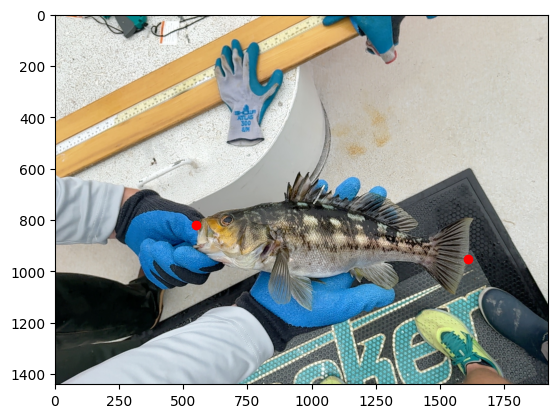

In [38]:
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
plt.plot(rgb_annotations[:, 0], rgb_annotations[:, 1], 'ro')

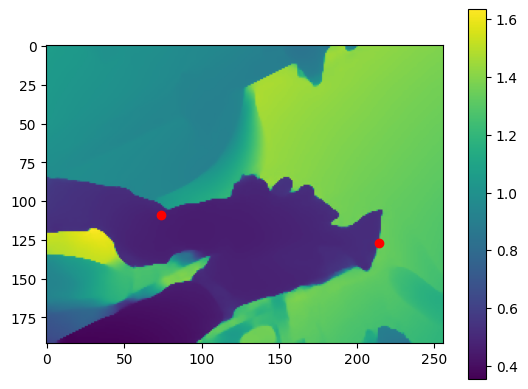

In [39]:
plt.imshow(depth_map)
plt.plot(depth_annotations[:, 0], depth_annotations[:, 1], 'ro')
plt.colorbar()

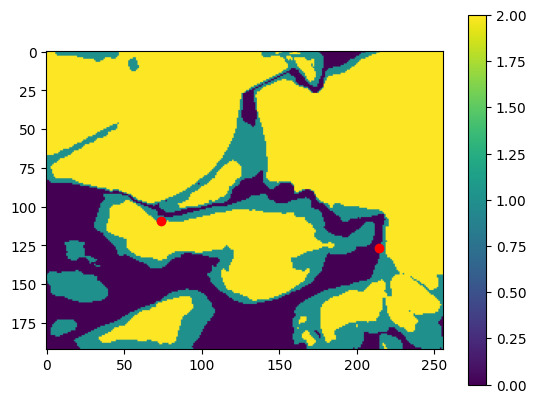

In [40]:
plt.imshow(confidence_map)
plt.plot(depth_annotations[:, 0], depth_annotations[:, 1], 'ro')
plt.colorbar()

In [38]:
df = pd.read_csv("/Users/sijanshrestha/Projects/e4e/2025-07-21_fishsense-mobile-data-processing/fish_length_prediction_with_pst.csv")

In [6]:
image = Image.open("/Users/sijanshrestha/Projects/e4e/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-06/iPad/FSM/rgb_1751571501.jpg")
image.show()

In [41]:
image = Image.open("/Users/sijanshrestha/Projects/e4e/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-05/iPad/FSM/rgb_1751472677.jpg")
image.show()

In [42]:
image = Image.open("/Users/sijanshrestha/Projects/e4e/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-06/iPad/FSM/rgb_1751571534.jpg")
image.show()

In [ ]:
timestamp 